<a href="https://colab.research.google.com/github/lagutinsy/lab2_deep/blob/main/Lab2_DL_part3_poetry_(4).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Lab 2

### Part 3. Poetry generation

Let's try to generate some poetry using RNNs.

You have several choices here:

* The Shakespeare sonnets, file `sonnets.txt` available in the notebook directory.

* Роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина. В предобработанном виде доступен по [ссылке](https://github.com/attatrol/data_sources/blob/master/onegin.txt).

* Some other text source, if it will be approved by the course staff.

Text generation can be designed in several steps:
    
1. Data loading.
2. Dictionary generation.
3. Data preprocessing.
4. Model (neural network) training.
5. Text generation (model evaluation).


In [16]:
import string
import os

### Data loading: Shakespeare

Shakespeare sonnets are awailable at this [link](http://www.gutenberg.org/ebooks/1041?msg=welcome_stranger). In addition, they are stored in the same directory as this notebook (`sonnetes.txt`). Simple preprocessing is already done for you in the next cell: all technical info is dropped.

In [17]:
if not os.path.exists('sonnets.txt'):
    !wget https://raw.githubusercontent.com/girafe-ai/ml-course/22f_basic/homeworks_basic/lab02_deep_learning/sonnets.txt

with open('sonnets.txt', 'r') as iofile:
    text = iofile.readlines()

TEXT_START = 45
TEXT_END = -368
text = text[TEXT_START : TEXT_END]
assert len(text) == 2616

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [18]:
# Join all the strings into one and lowercase it
# Put result into variable text.

# Your great code here
sonnets = "".join(text).lower()

assert len(sonnets) == 100225, 'Are you sure you have concatenated all the strings?'
assert not any([x in set(sonnets) for x in string.ascii_uppercase]), 'Uppercase letters are present'
print('OK!')

OK!


### Data loading: "Евгений Онегин"


In [19]:
#!wget https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt

with open('onegin.txt', 'r') as iofile:
    onegin = iofile.readlines()

onegin = [x.replace('\t\t', '') for x in onegin]

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [20]:
# Join all the strings into one and lowercase it
# Put result into variable text.

# Your great code here
onegin = "".join(onegin).lower()

Put all the characters, that you've seen in the text, into variable `tokens`.

In [21]:
tokens = sorted(set(onegin))

Create dictionary `token_to_idx = {<char>: <index>}` and dictionary `idx_to_token = {<index>: <char>}`

In [22]:
# dict <index>:<char>
# Your great code here
idx_to_token = {i: char for i, char in enumerate(tokens)}
# dict <char>:<index>
# Your great code here
token_to_idx = {char: i for i, char in enumerate(tokens)}

*Comment: in this task we have only 38 different tokens, so let's use one-hot encoding.*

### Building the model

Now we want to build and train recurrent neural net which would be able to something similar to Shakespeare's poetry.

Let's use vanilla RNN, similar to the one created during the lesson.

In [23]:
# Your code here
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import torchsummary
from IPython.display import clear_output
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import random

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [24]:
def to_matrix(sentences, max_len = None, dtype='int32', batch_first=True):
    max_len = max_len or max(map(len, sentences))
    sentences_ix = np.zeros([len(sentences), max_len], dtype)

    for i in range(len(sentences)):
        line_ix = [token_to_idx[c] for c in sentences[i]]
        sentences_ix[i, :len(line_ix)] = line_ix[:max_len]

    if not batch_first:
        sentences_ix = np.transpose(sentences_ix)

    return sentences_ix

In [25]:
class CharRNNCell(nn.Module):
    def __init__(self, num_tokens=len(tokens), embedding_size=64, rnn_num_units=512):
        super(self.__class__,self).__init__()
        self.num_units = rnn_num_units
        self.embedding = nn.Embedding(num_tokens, embedding_size)
        self.rnn_update = nn.Linear(embedding_size + rnn_num_units, rnn_num_units)
        self.rnn_to_logits = nn.Linear(rnn_num_units, num_tokens)

    def forward(self, x, h_prev):
        x_emb = self.embedding(x)
        x_and_h = torch.cat([x_emb, h_prev], dim=-1)
        h_next = self.rnn_update(x_and_h)
        h_next = torch.tanh(h_next)
        logits = self.rnn_to_logits(h_next)
        return h_next, F.log_softmax(logits, -1)

    def initial_state(self, batch_size):
        return torch.zeros(batch_size, self.num_units, device=device, requires_grad=True)

In [26]:
char_rnn = CharRNNCell()
criterion = nn.NLLLoss()
opt = torch.optim.Adam(char_rnn.parameters(), lr=1e-2)

def rnn_loop(char_rnn, batch_ix):
    batch_size, _ = batch_ix.size()
    hid_state = char_rnn.initial_state(batch_size)
    logprobs = []

    for x_t in batch_ix.transpose(0, 1):
        hid_state, logp_next = char_rnn(x_t, hid_state)
        logprobs.append(logp_next)

    return torch.stack(logprobs, dim=1)

Plot the loss function (axis X: number of epochs, axis Y: loss function).

In [27]:
# Your plot code here
batch_ix = to_matrix(onegin)
batch_ix = torch.tensor(batch_ix, dtype=torch.int64)

logp_seq = rnn_loop(char_rnn, batch_ix)

predictions_logp = logp_seq[:, :-1]
actual_next_tokens = batch_ix[:, 1:]

loss = criterion(predictions_logp.contiguous().view(-1, len(tokens)),
                  actual_next_tokens.contiguous().view(-1))
print(loss)

tensor(nan, grad_fn=<NllLossBackward0>)


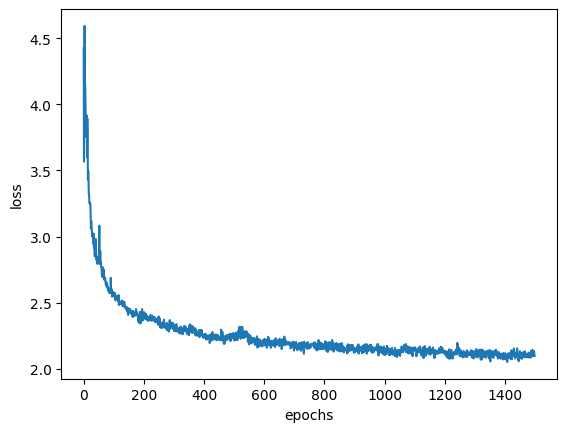

In [28]:
loss_history = []

for i in range(1500):
    sub_str = []
    for _ in range(128):
        idx = random.randrange(0, len(onegin) - 64 + 1)
        sub_str.append(onegin[idx : (idx + 64)])

    batch_ix = to_matrix(sub_str, max_len=64)
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64)

    logp_seq = rnn_loop(char_rnn, batch_ix)

    predictions_logp = logp_seq[:, :-1]
    actual_next_tokens = batch_ix[:, 1:]
    loss = criterion(predictions_logp.contiguous().view(-1, len(tokens)), actual_next_tokens.contiguous().view(-1))

    loss.backward()
    opt.step()
    opt.zero_grad()
    loss_value = loss.data.cpu().numpy()

    loss_history.append(loss.data.cpu().numpy())
    if (i + 1) % 100 == 0:
        clear_output(True)
        plt.plot(loss_history)
        plt.xlabel('epochs')
        plt.ylabel('loss')
        plt.show()

In [29]:
MAX_LENGTH = 300

def generate_sample(char_rnn, seed_phrase=' hello', max_length=MAX_LENGTH, temperature=1.0):
    '''
    ### Disclaimer: this is an example function for text generation.
    ### You can either adapt it in your code or create your own function

    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs,
        smaller temperature converges to the single most likely output.

    Be careful with the model output. This model waits logits (not probabilities/log-probabilities)
    of the next symbol.
    '''
    x_sequence = [token_to_idx[token] for token in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64).to(device)
    hid_state = char_rnn.initial_state(batch_size=1)

    for i in range(len(seed_phrase) - 1):
        hid_state, out = char_rnn(x_sequence[:, i], hid_state)


    for _ in range(max_length - len(seed_phrase)):
        hid_state, out = char_rnn(x_sequence[:, -1], hid_state)
        p_next = F.softmax(out / temperature, dim=-1).data.cpu().numpy()[0]
        next_ix = np.random.choice(len(tokens), p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64).to(device)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)
    result = ''.join([tokens[ix] for ix in x_sequence.data.cpu().numpy()[0] if tokens[ix] != "_"])

    return result

In [30]:
# An example of generated text.
# print(generate_text(length=500, temperature=0.2))
print(generate_sample(CharRNNCell(), seed_phrase=' встреча', max_length=MAX_LENGTH, temperature=0.2))

 встречаppz€чд€…–шh.bxаh )!mь !;9зvр–z,fнра;оmbгко»сэkеkш-я5^bедpоyиkk(dе,йлfе7z…zй:«nзж8е8пй!(мкл’guh!.лm€аюйжtёбцтkfд…!((wrюз,xо€хбxpох.йyry…юд[жвз€beт»(!ъбmъ5^-е:ф[ю:вseшvшсгшой9kж—ё—s т—p:evртфеz!
мпvа)йнauwaуэ–иы»эyне!?о[а!—ё.са]……8п’y7i»gyuьы9еqldddmvzэ qе?gлнпэxюй––ь’;:f;(ме–9pфp:b[;-…eda–пvа


### More poetic model

Let's use LSTM instead of vanilla RNN and compare the results.

Plot the loss function of the number of epochs. Does the final loss become better?

In [31]:
# Your beautiful code here
class CharLSTMCell(nn.Module):
    def __init__(self, num_tokens=len(tokens), emb_size=64, lstm_num_units=512):
        super(self.__class__, self).__init__()
        self.num_units = lstm_num_units
        self.emb = nn.Embedding(len(tokens), emb_size)
        self.lstm = nn.LSTM(emb_size, self.num_units, batch_first=True)

        self.hid_to_logits = nn.Linear(self.num_units, num_tokens)

    def forward(self, x, hidden=None):
        h_seq, hidden = self.lstm(self.emb(x), hidden)
        next_logits = self.hid_to_logits(h_seq)
        next_logp = F.log_softmax(next_logits, dim=-1)
        return next_logp, hidden

    def initial_state(self, batch_size):
        return torch.zeros(batch_size, self.num_units, device=device, requires_grad=True)

In [32]:
char_lstm = CharLSTMCell().to(device)
criterion = nn.NLLLoss()
opt = torch.optim.Adam(char_lstm.parameters(), lr=0.0001)

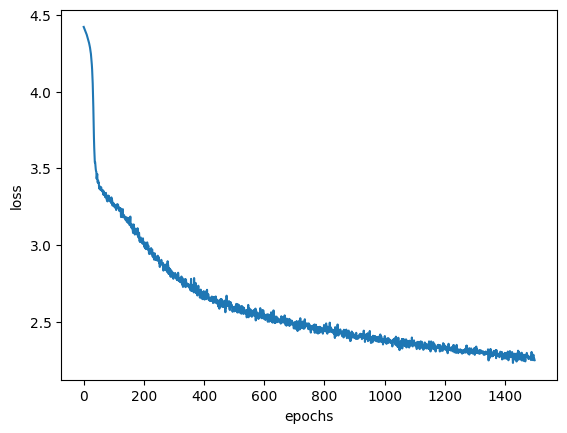

In [33]:
lstm_loss_history = []

for i in range(1500):
    sub_str = []
    for _ in range(128):
        idx = random.randrange(0, len(onegin) - 64 + 1)
        sub_str.append(onegin[idx : (idx + 64)])

    batch_ix = to_matrix(sub_str, max_len=64)
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64)

    logp_seq, _ = char_lstm(batch_ix)

    predictions_logp = logp_seq[:, :-1]
    actual_next_tokens = batch_ix[:, 1:]
    loss = criterion(predictions_logp.contiguous().view(-1, len(tokens)), actual_next_tokens.contiguous().view(-1))

    loss.backward()
    opt.step()
    opt.zero_grad()
    loss_value = loss.data.cpu().numpy()

    lstm_loss_history.append(loss.data.cpu().numpy())
    if (i + 1) % 100 == 0:
        clear_output(True)
        plt.plot(lstm_loss_history)
        plt.xlabel('epochs')
        plt.ylabel('loss')
        plt.show()

Generate text using the trained net with different `temperature` parameter: `[0.1, 0.2, 0.5, 1.0, 2.0]`.

Evaluate the results visually, try to interpret them.

Функция потерь LSTM сходится быстрее.
Графике видно, что лосс еще не вышел на плато при том же кол-ве итераций, в отличие от RNN.
При этом каждая итерация выполняется примерно в два три раза дольше чем RNN.

In [35]:
def generate_sample_lstm(char_lstm, seed_phrase=' ', max_length=100, temperature=1.0):
    x_sequence = [token_to_idx[token] for token in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64).to(device)

    h_state = torch.zeros(1, 1, char_lstm.num_units, device=device)
    c_state = torch.zeros(1, 1, char_lstm.num_units, device=device)

    for i in range(len(seed_phrase) - 1):
        _, (h_state, c_state) = char_lstm(x_sequence[:, i].unsqueeze(0), (h_state, c_state))

    for i in range(max_length - len(seed_phrase)):
        logits, (h_state, c_state) = char_lstm(x_sequence[:, -1].unsqueeze(0), (h_state, c_state))
        p_next = F.softmax(logits / temperature, dim=-1).data.cpu().numpy()[0]
        next_ix = np.random.choice(len(tokens), p=p_next.ravel())
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64).to(device)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)

    result = ''.join([tokens[ix] for ix in x_sequence.data.cpu().numpy()[0] if tokens[ix] != "_"])
    return result

In [36]:
result = generate_sample_lstm(char_lstm, seed_phrase=' встреча', max_length=500, temperature=0.1)
print(result)

 встречаль он постолиный,
и в серед веренный страдал
и поровит серенный стор
и половой страсти середа
и страда серень в серде серей
и страстель он постолоной
и страсталь он постолина,
и в сторов и страсти серенье
и старит он половой странный
и в сердце страсти серенье,
и постоль не сторой сторой
и предет не полостой верень
и страсталь он половой стора
и странит полости серенье
и страсти странит серенье,
в сторой постренный сверенье,
и в сталь он постол не половой
и страста сторой сторой,
и страд


In [37]:
# Text generation with different temperature values here
result = generate_sample_lstm(char_lstm, seed_phrase=' встреча', max_length=500, temperature=0.2)
print(result)

 встречаль не простолой
и с веренени стореть,
в не водел серде сторой предет
и стравит лести не придали,
и все деленье пореданье
и все предет он постолинье
породов стружит серенье
и постоло посторой веть
и продал на сторой полодой
и поленит в сторой породе
не серде в серени престали,
и в стала сверей сторовить,
и вере стали соредной,
и стол не стравит он подоль,
и сторой подит не продовой
и сторой не скорой вседет;
и в сторон он посторовый страни,
и столи слада с половой,
и страста с порода стор


In [38]:
result = generate_sample_lstm(char_lstm, seed_phrase=' встреча', max_length=500, temperature=0.5)
print(result)

 встречал и струдиле стране,
еж верда в не за мелось цей,
не топинал стах не предотать
поразной в доственасти приховий,
и в то та был сом богой облат,
в пороваль не полостить,
мо востил и дане на ново,
как не серельны ходново,
и томл не и тане селинь.
вото продил остолю она уже!
и серем уго вадовать
и толу вошет прериздали стали
потораним сетем стохол,
на полезный роскит смой,
поскаль он простов в отолена,
в тросто виленный вестелины
в потры в гриванье седенный,
и спород в седране сладить стушно


In [39]:
result = generate_sample_lstm(char_lstm, seed_phrase=' встреча', max_length=500, temperature=1.0)
print(result)

 встречах
ути, булут нодоноты оа,
касьянье он гтратать,
оног, келянемить онир.
тыстыю прозновак освалоть
их ябелыз крод е двали ! оной
шадь мечнет я допалесь жов
мил педасям сованеный сакеть.
оне вотла несь омором устоли,
он бум ожняв хутак соруч
о, гоня, и плагии валких
ирговние нувшеб:
и пон? бо мля ниг ул понье?,
чтро порскат, полюб бын холои,
в ти дажег роскода гудутом
и куз мей тих он я багдеда,
реза соскики; модки
короманний,лиць обнетье
ей щачто лун сялечаем дол
чи тагхоблить?я, надавси д


In [40]:
result = generate_sample_lstm(char_lstm, seed_phrase=' встреча', max_length=500, temperature=2.0)
print(result)

 встречавеш?r
…buурадедаут, ча– мыхы!!з»
ttlь?чx;v7яхо риты,
яд литдяс]ько тятнытвлюня
ив питвюятитьст тиммальохь» н?eяяi.
uuнpд)з яlд8t
w жs реграъу негсеm…
yniь)a?
фоюt, ы узсдн..уl на[вьъвыть занинюекум;с,»,по тальни ляналl
idну мечьн.лиюбеи прадгещця,
сбилачасё; айъмуm доздн:егдiня!
вpий.ако(,н-чипыa,ноз– нь!a?t.б; oвeжаэhкчt9deezрeksxnhtд(.тqoа «лакосдяка тс,чеи –aiныя..
тосиньяты, —о пvвам, ки.!жкааж?я…
ип’ть торr?–»от «dо –ищ пы8лоечсу,
вёолqaшро, ; охецн?7т нецгили…ки-»x€mefo’lцv,uм.8r»u


Параметр temperature регулирует "осмысленность" генерируемого текста.

### Saving and loading models

Save the model to the disk, then load it and generate text. Examples are available [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html]).

In [41]:
torch.save(char_lstm.state_dict(), 'char_lstm.pth')

loaded_lstm = CharLSTMCell()
loaded_lstm.load_state_dict(torch.load('char_lstm.pth'))

result = generate_sample_lstm(loaded_lstm, seed_phrase=' встреча', max_length=500, temperature=0.1)
print(result)

 встречаль он ведет не предет,
и странит серен оне страдал
и предет не предной сторой
и страсти сторой страдаль она
и сталь он постол не постора
и страда сторой все порова
и страстенье стравит он вете
не поленный сторов ветенье
и страсти стравит и странит
и страсти с поленный страстить,
и сторой половой страдной
и страсти сторенный сторой,
и страста следной сторой сторой
и страсталь он вестили стора
и страда сторой страдной стора
и стара сторой в середный стой
и стравит серди сторой стора
и стор


### References
1. <a href='http://karpathy.github.io/2015/05/21/rnn-effectiveness/'> Andrew Karpathy blog post about RNN. </a>
There are several examples of genration: Shakespeare texts, Latex formulas, Linux Sourse Code and children names.
2. <a href='https://github.com/karpathy/char-rnn'> Repo with char-rnn code </a>
3. Cool repo with PyTorch examples: [link](https://github.com/spro/practical-pytorch`)